# import

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
os.environ["MKL_NUM_THREADS"] = "2"
os.environ["NUMEXPR_NU M_THREADS"] = "2"
os.environ["OMP_NUM_THREADS"] = "2"
import time

import numpy as np
import torch
import torch.nn as nn
import torch.utils.data as data
import torch.nn.functional as F
from torch.optim.lr_scheduler import LambdaLR
from torch.utils.tensorboard import SummaryWriter
from advertorch.attacks import GradientSignAttack

In [3]:
from ubs8k.datasetManager import DatasetManager
from ubs8k.datasets import Dataset

import sys
sys.path.append("../..")

from util.utils import reset_seed, get_datetime, get_model_from_name, ZipCycle, load_dataset
from metric_utils.metrics import CategoricalAccuracy, FScore, ContinueAverage, Ratio
from util.checkpoint import CheckPoint

from UrbanSound8k.ramps import Warmup, sigmoid_rampup, sigmoid_rampdown
from UrbanSound8k.losses import loss_cot, loss_diff, loss_sup

# Arguments

In [34]:
import argparse
parser = argparse.ArgumentParser()


parser.add_argument("-d", "--dataset_root", default="../../datasets", type=str)
parser.add_argument("-D", "--dataset", default="cifar10", type=str, help="available [ubs8k | cifar10]")
# parser.add_argument("--supervised_mult", default=1.0, type=float)

group_t = parser.add_argument_group("Commun parameters")
group_t.add_argument("-m", "--model", default="cnn03", type=str)
group_t.add_argument("--supervised_ratio", default=0.1, type=float)
group_t.add_argument("--batch_size", default=100, type=int)
group_t.add_argument("--nb_epoch", default=1000, type=int)
group_t.add_argument("--learning_rate", default=0.0005, type=float)
group_t.add_argument("--resume", action="store_true", default=False)
group_t.add_argument("--seed", default=1234, type=int)

group_u = parser.add_argument_group("UrbanSound8k parameters")
group_u.add_argument("-t", "--train_folds", nargs="+", default=[1, 2, 3, 4, 5, 6, 7, 8, 9], type=int)
group_u.add_argument("-v", "--val_folds", nargs="+", default=[10], type=int)

group_c = parser.add_argument_group("Cifar10 parameters")

group_h = parser.add_argument_group('hyperparameters')
group_h.add_argument("--lambda_cot_max", default=1, type=float)
group_h.add_argument("--lambda_diff_max", default=1, type=float)
group_h.add_argument("--warmup_length", default=1000, type=int)
group_h.add_argument("--epsilon", default=0.02, type=float)

group = parser.add_argument_group('uniloss')
group.add_argument("--loss_scheduler", default="weighted-linear", type=str)
group.add_argument("--steps", default=10, type=int)
group.add_argument("--cycle", default=1, type=int)
group.add_argument("--beta", default=1, type=int)
group.add_argument("--plsup_mini", default=0.0, type=float)

group_a = parser.add_argument_group("Augmentation")
group_a.add_argument("--augment", action="append", help="augmentation. use as if python script")
group_a.add_argument("--augment_S", action="store_true", help="Apply augmentation on Supervised part")
group_a.add_argument("--augment_U", action="store_true", help="Apply augmentation on Unsupervised part")

group_l = parser.add_argument_group("Logs")
group_l.add_argument("--checkpoint_path", default="../../model_save/ubs8k/deep-co-training_independant-loss", type=str)
group_l.add_argument("--tensorboard_path", default="../../tensorboard/ubs8k/deep-co-training_independant-loss", type=str)
group_l.add_argument("--tensorboard_sufix", default="", type=str)

args = parser.parse_args("")

In [35]:
args

Namespace(augment=None, augment_S=False, augment_U=False, batch_size=100, beta=1, checkpoint_path='../../model_save/ubs8k/deep-co-training_independant-loss', cycle=1, dataset='cifar10', dataset_root='../../datasets', epsilon=0.02, lambda_cot_max=1, lambda_diff_max=1, learning_rate=0.0005, loss_scheduler='weighted-linear', model='cnn03', nb_epoch=1000, plsup_mini=0.0, resume=False, seed=1234, steps=10, supervised_ratio=0.1, tensorboard_path='../../tensorboard/ubs8k/deep-co-training_independant-loss', tensorboard_sufix='', train_folds=[1, 2, 3, 4, 5, 6, 7, 8, 9], val_folds=[10], warmup_length=1000)

In [27]:
reset_seed(1234)

## Prepare the dataset

In [7]:
# audio_root = os.path.join(args.dataset_root, "audio")
# metadata_root = os.path.join(args.dataset_root, "metadata")
# all_folds = args.train_folds + args.val_folds

# manager = DatasetManager(
#     metadata_root, audio_root,
#     folds=all_folds,
#     verbose=2
# )


## Rules makers

In [8]:
def uniform_rule(step: int = 0, **kwargs):
    sup_steps = [0.34 for _ in range(step)]
    cot_steps = [0.33 for _ in range(step)]
    diff_steps = [0.33 for _ in range(step)]
    
    return sup_steps, cot_steps, diff_steps


def weighted_uniform_rule(step: int = 10, **kwargs):
    lcm = args.lambda_cot_max
    ldm = args.lambda_diff_max
    lsm = 1
    
    sup_steps = [lsm * 0.34 for _ in range(step)]
    cot_steps = [lcm * 0.33 for _ in range(step)]
    diff_steps = [ldm * 0.33 for _ in range(step)]
    
    # normalize
    for i in range(step):
        summed = sup_steps[i] + cot_steps[i] + diff_steps[i]
        sup_steps[i] /= summed
        cot_steps[i] /= summed
        diff_steps[i] /= summed
        
    return sup_steps, cot_steps, diff_steps

def linear_rule(step: int = 10, plsup_mini = 0.0, **kwargs):
    lcm = args.lambda_cot_max
    ldm = args.lambda_diff_max
    lsm = 0
    
    s_start, s_end = 1, lsm 
    c_start, c_end = 0, lcm
    d_start, d_end = 0, ldm
    
    # normalize
    total = s_end + c_end + d_end
    s_end /= total
    c_end /= total
    d_end /= total
    
    if s_end < plsup_mini:
        s_end = plsup_mini
        c_end = c_end - (plsup_mini / 2)
        d_end = d_end - (plsup_mini / 2)
    
    sup_steps = np.linspace(s_start, s_end, step)
    cot_steps = np.linspace(d_start, c_end, step)
    diff_steps = np.linspace(d_start, d_end, step)
    
    return sup_steps, cot_steps, diff_steps

def weighted_linear_rule(step: int = 10, **kwargs):
    lcm = args.lambda_cot_max
    ldm = args.lambda_diff_max
    lsm = 1
    total = lcm + ldm + lsm
    
    # normalize
    lcm /= total
    ldm /= total
    lsm /= total
    
    sup_steps = np.linspace(1, lsm, step)
    cot_steps = np.linspace(0, lcm, step)
    diff_steps = np.linspace(0, ldm, step)
    
    return sup_steps, cot_steps, diff_steps

def cosine_rule(step: int = 10, cycle: int = 1, **kwargs):
    hop_length = np.linspace(0, args.nb_epoch, step * cycle)
    
    sup_steps = 0.5 * (np.cos(np.pi * hop_length / (args.nb_epoch / cycle)) + 1)
    cot_steps = 1 - (0.5 * (np.cos(np.pi * hop_length / (args.nb_epoch / cycle)) + 1))
    diff_steps =  1 - (0.5 * (np.cos(np.pi * hop_length / (args.nb_epoch / cycle)) + 1))
    
    # normalize
    for i in range(step * cycle):
        summed = sup_steps[i] + cot_steps[i] + diff_steps[i]
        sup_steps[i] /= summed
        cot_steps[i] /= summed
        diff_steps[i] /= summed
        
    return sup_steps, cot_steps, diff_steps

def weighted_cosine_rule(step: int = 10, cycle: int = 1, **kwargs):
    lcm = args.lambda_cot_max
    ldm = args.lambda_diff_max
    lsm = 1
    
    hop_length = np.linspace(0, args.nb_epoch, step * cycle)
    
    sup_steps = 0.5 * (np.cos(np.pi * hop_length / (args.nb_epoch / cycle)) + 1)
    cot_steps = 1 - (0.5 * (np.cos(np.pi * hop_length / (args.nb_epoch / cycle)) + 1))
    diff_steps =  1 - (0.5 * (np.cos(np.pi * hop_length / (args.nb_epoch / cycle)) + 1))
    
    sup_steps *= lsm
    cot_steps *= lcm
    diff_steps *= ldm
    
    # normalize
    for i in range(step * cycle):
        summed = sup_steps[i] + cot_steps[i] + diff_steps[i]
        sup_steps[i] /= summed
        cot_steps[i] /= summed
        diff_steps[i] /= summed
        
    return sup_steps, cot_steps, diff_steps

def annealing_cosine_rule(step: int = 10, cycle: int = 1, beta: float = 2, **kwargs):
    hop_length = np.linspace(0, args.nb_epoch, step * cycle)
    
    # create original steps
    decaying =  np.exp(-beta * np.linspace(0, 1, len(hop_length)))
    
    sup_steps = 0.5 * (decaying * np.cos(np.pi * hop_length / (args.nb_epoch / cycle)) + 1)
    cot_steps = 1 - (0.5 * (decaying * np.cos(np.pi * hop_length / (args.nb_epoch / cycle)) + 1))
    diff_steps =  1 - (0.5 * (decaying * np.cos(np.pi * hop_length / (args.nb_epoch / cycle)) + 1))
    
    # normalize
    for i in range(step * cycle):
        summed = sup_steps[i] + cot_steps[i] + diff_steps[i]
        sup_steps[i] /= summed
        cot_steps[i] /= summed
        diff_steps[i] /= summed
        
    return sup_steps, cot_steps, diff_steps

def weighted_annealing_cosine_rule(step: int = 10, cycle: int = 1, beta: float = 2, **kwargs):
    lcm = args.lambda_cot_max
    ldm = args.lambda_diff_max
    lsm = 1
    
    print("step: ", step)
    print("cycle: ", cycle)
    print("beta: ", beta)
    
    hop_length = np.linspace(0, args.nb_epoch, step * cycle)
    
    # create original steps
    decaying =  np.exp(-beta * np.linspace(0, 1, len(hop_length)))
    
    sup_steps = 0.5 * (decaying * np.cos(np.pi * hop_length / (args.nb_epoch / cycle)) + 1)
    cot_steps = 1 - (0.5 * (decaying * np.cos(np.pi * hop_length / (args.nb_epoch / cycle)) + 1))
    diff_steps =  1 - (0.5 * (decaying * np.cos(np.pi * hop_length / (args.nb_epoch / cycle)) + 1))
    
    sup_steps *= lsm
    cot_steps *= lcm
    diff_steps *= ldm
    
    # normalize
    for i in range(step * cycle):
        summed = sup_steps[i] + cot_steps[i] + diff_steps[i]
        sup_steps[i] /= summed
        cot_steps[i] /= summed
        diff_steps[i] /= summed
        
    return sup_steps, cot_steps, diff_steps

def sigmoid_rule(step: int = 10, **kwargs):
    hop_length = np.linspace(0, args.nb_epoch, step)
    
    sup_steps = np.asarray([sigmoid_rampdown(x, args.nb_epoch) for x in hop_length])
    cot_steps = np.asarray([sigmoid_rampup(x, args.nb_epoch) for x in hop_length])
    diff_steps = np.asarray([sigmoid_rampup(x, args.nb_epoch) for x in hop_length])
    
    # normalize
    for i in range(step):
        summed = sup_steps[i] + cot_steps[i] + diff_steps[i]
        sup_steps[i] /= summed
        cot_steps[i] /= summed
        diff_steps[i] /= summed
        
    return sup_steps, cot_steps, diff_steps

def weighted_sigmoid_rule(step: int = 10, **kwargs):
    lcm = args.lambda_cot_max
    ldm = args.lambda_diff_max
    lsm = 1

    hop_length = np.linspace(0, args.nb_epoch, step)
    
    sup_steps = np.asarray([lsm * sigmoid_rampdown(x, args.nb_epoch) for x in hop_length])
    cot_steps = np.asarray([lcm * sigmoid_rampup(x, args.nb_epoch) for x in hop_length])
    diff_steps = np.asarray([ldm * sigmoid_rampup(x, args.nb_epoch) for x in hop_length])
    
    # normalize
    for i in range(step):
        summed = sup_steps[i] + cot_steps[i] + diff_steps[i]
        sup_steps[i] /= summed
        cot_steps[i] /= summed
        diff_steps[i] /= summed
        
    return sup_steps, cot_steps, diff_steps

def loss_chooser(epoch):
    for k in reversed(rules.keys()):
        if epoch >= k:
            chance = list(rules[k].values())
            break
    
    loss_function = ["sup", "cot", "diff"]
    return np.random.choice(loss_function, p=chance)

def rule_maker(rule_fn, steps: int = 10, **kwargs):
    p_lsup, p_lcot, p_ldiff = rule_fn(steps, **kwargs)
    
    hop_length = np.linspace(0, args.nb_epoch, len(p_lsup))
    
    rules = dict()
    for i, epoch in enumerate(hop_length):
        rules[epoch] = {"lsup": p_lsup[i], "lcot": p_lcot[i], "ldiff": p_ldiff[i]}
        
    return rules

def rule_chooser(rule_str):
    mapper = {
        "uniform": uniform_rule,
        "weighted-uniform": weighted_uniform_rule,
        "linear": linear_rule,
        "weighted-linear": weighted_linear_rule,
        "sigmoid": sigmoid_rule,
        "weighted-sigmoid": weighted_sigmoid_rule,
        "cosine": cosine_rule,
        "weighted-cosine": weighted_cosine_rule,
        "annealing-cosine": annealing_cosine_rule,
        "weighted-annealing-cosine": weighted_annealing_cosine_rule,
    }
    
    if rule_str not in mapper:
        raise ValueError("Loss scheduler must be from [%s]" % (", ".join(mapper.keys())))
        
    return mapper[rule_str]

def weighted_linear_rule(step: int = 10, **kwargs):
    lcm = args.lambda_cot_max
    ldm = args.lambda_diff_max
    lsm = 1
    total = lcm + ldm + lsm
    
    # normalize
    lcm /= total
    ldm /= total
    lsm /= total
    
    sup_steps = np.linspace(1, lsm, step)
    cot_steps = np.linspace(0, lcm, step)
    diff_steps = np.linspace(0, ldm, step)
    
    return sup_steps, cot_steps, diff_steps


In [9]:
scheduler_args = dict(
    steps = args.steps,
    cycle=args.cycle,
    beta=args.beta,
    plsup_mini=0.0,
)

rule_fn = rule_chooser(args.loss_scheduler)
print(rule_fn)
rules = rule_maker(rule_fn, **scheduler_args)

<function weighted_linear_rule at 0x7f73cfbc73a0>


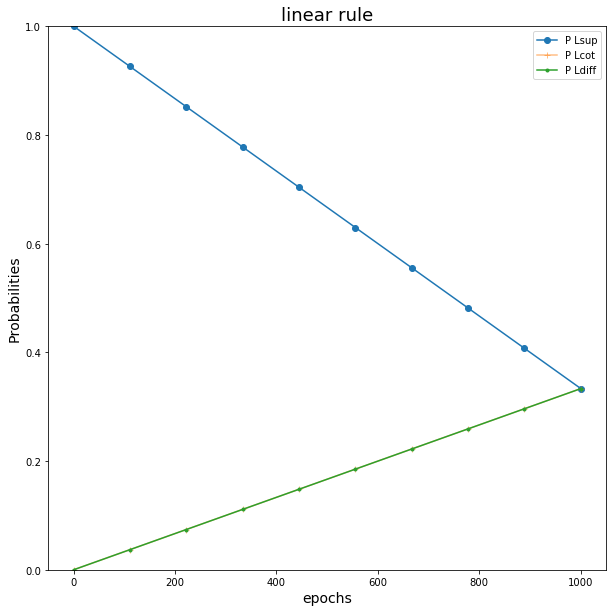

In [10]:
def create_fig(rules):
    import matplotlib.pyplot as plt
    lsup = np.asarray([rules[k]["lsup"] for k in rules])
    lcot = np.asarray([rules[k]["lcot"] for k in rules])
    ldiff = np.asarray([rules[k]["ldiff"] for k in rules])
    steps = [k for k in rules]
    xticks = ["%d" % s for s in steps]


    fig = plt.figure(0, figsize=(10, 10))
    plt.title("linear rule", fontsize=18)
    plt.xlabel("epochs", fontsize=14)
    plt.ylabel("Probabilities", fontsize=14)
    plt.ylim(0, 1)

    # plt.bar(range(len(steps)), lsup, bottom=0, label="P lsup")
    # plt.bar(range(len(steps)), lcot, bottom=lsup, label="P lcot")
    # plt.bar(range(len(steps)), ldiff, bottom=lsup+lcot, label="P ldiff")
#     plt.xticks(range(len(steps)), xticks)

    plt.plot(steps, lsup, marker="o", label="P Lsup")
    plt.plot(steps, lcot, marker="+", label="P Lcot", alpha=0.5)
    plt.plot(steps, ldiff, marker=".", label="P Ldiff")
#     plt.xticks(steps, xticks)

    plt.legend()
    plt.show()
    
    return fig
fig = create_fig(rules)

# Load the dataset and create the dataloader

In [38]:
manager, train_loader, val_loader = load_dataset(
    args.dataset,
    dataset_root = args.dataset_root,
    supervised_ratio = args.supervised_ratio,
    batch_size = args.batch_size,
    train_folds = args.train_folds,
    val_folds = args.val_folds,
    verbose = 2
)

Files already downloaded and verified
Files already downloaded and verified


## Models

In [23]:
torch.cuda.empty_cache()
model_func = get_model_from_name(args.model)

m1, m2 = model_func(manager=manager), model_func(manager=manager)

m1 = m1.cuda()
m2 = m2.cuda()

## Adversarial generator

In [24]:
# adversarial generation
adv_generator_1 = GradientSignAttack(
    m1, loss_fn=nn.CrossEntropyLoss(reduction="sum"),
    eps=args.epsilon, clip_min=-80, clip_max=0, targeted=True
)

adv_generator_2 = GradientSignAttack(
    m2, loss_fn=nn.CrossEntropyLoss(reduction="sum"),
    eps=args.epsilon, clip_min=-80, clip_max=0, targeted=True
)

## training parameters

In [27]:
# tensorboard
tensorboard_title = "%s_%s_%.1f_%se_%slr_%sw_%s-rfn_%ss" % (get_datetime(), model_func.__name__, args.supervised_ratio, args.nb_epoch, args.learning_rate, args.warmup_length, rule_fn.__name__, args.steps)
checkpoint_title =  "%s_%.1f_%se_%slr_%sw_%s-rfn_%ss" % (model_func.__name__, args.supervised_ratio, args.nb_epoch, args.learning_rate, args.warmup_length, rule_fn.__name__, args.steps)
tensorboard = SummaryWriter(log_dir="%s/%s" % (args.tensorboard_path, tensorboard_title), comment=model_func.__name__)

# Losses
# see losses.py

# Optimizer
params = list(m1.parameters()) + list(m2.parameters())
optimizer = torch.optim.Adam(params, lr=args.learning_rate)

# define the warmups
lambda_cot = Warmup(args.lambda_cot_max, args.warmup_length, sigmoid_rampup)
lambda_diff = Warmup(args.lambda_diff_max, args.warmup_length, sigmoid_rampup)

# callback
lr_lambda = lambda epoch: (1.0 + np.cos((epoch-1) * np.pi / args.nb_epoch))
lr_scheduler = LambdaLR(optimizer, lr_lambda)
callbacks = [lr_scheduler, lambda_cot, lambda_diff]

# checkpoints
checkpoint_m1 = CheckPoint(m1, optimizer, mode="max", name="%s/%s_m1.torch" % (args.checkpoint_path, checkpoint_title))

# metrics
metrics_fn = dict(
    ratio_s=[Ratio(), Ratio()],
    ratio_u=[Ratio(), Ratio()],
    acc_s=[CategoricalAccuracy(), CategoricalAccuracy()],
    acc_u=[CategoricalAccuracy(), CategoricalAccuracy()],
    f1_s=[FScore(), FScore()],
    f1_u=[FScore(), FScore()],
    
    avg_total=ContinueAverage(),
    avg_sup=ContinueAverage(),
    avg_cot=ContinueAverage(),
    avg_diff=ContinueAverage(),
)

def reset_metrics():
    for item in metrics_fn.values():
        if isinstance(item, list):
            for f in item:
                f.reset()
        else:
            item.reset()

In [28]:
reset_metrics()

## Can resume previous training

In [29]:
args.resume

False

In [30]:
if args.resume:
    checkpoint_m1.load_last()

## Metrics and hyperparameters

In [31]:
def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']
    
def maximum():
    def func(key, value):
        if key not in func.max:
            func.max[key] = value
        else:
            if func.max[key] < value:
                func.max[key] = value
        return func.max[key]

    func.max = dict()
    return func
maximum_fn = maximum()

# Training functions

In [32]:
UNDERLINE_SEQ = "\033[1;4m"

RESET_SEQ = "\033[0m"


header_form = "{:<8.8} {:<6.6} - {:<6.6} - {:<8.8} {:<6.6} | {:<6.6} | {:<6.6} | {:<6.6} - {:<9.9} {:<9.9} | {:<9.9}- {:<6.6}"
value_form  = "{:<8.8} {:<6} - {:<6} - {:<8.8} {:<6.4f} | {:<6.4f} | {:<6.4f} | {:<6.4f} - {:<9.9} {:<9.4f} | {:<9.4f}- {:<6.4f}"

header = header_form.format(
    "", "Epoch", "%", "Losses:", "Lsup", "Lcot", "Ldiff", "total", "metrics: ", "acc_s1", "acc_u1","Time"
)

train_form = value_form
val_form = UNDERLINE_SEQ + value_form + RESET_SEQ

def mprint(epoch, msg, end):
    if epoch % 10 == 0:
        print(msg, end=end)
        
print(header)

         Epoch  - %      - Losses:  Lsup   | Lcot   | Ldiff  | total  - metrics:  acc_s1    | acc_u1   - Time  


## Train sup

In [33]:
def train_sup_helper(start_time, epoch, batch, x_s1, x_s2, y_s1, y_s2):
    x_s1, x_s2, = x_s1.cuda(), x_s2.cuda()
    y_s1, y_s2, = y_s1.cuda(), y_s2.cuda()

    logits_s1 = m1(x_s1)
    logits_s2 = m2(x_s2)

    l_sup = loss_sup(logits_s1, logits_s2, y_s1, y_s2)
    total_loss = l_sup
    
    optimizer.zero_grad()
    total_loss.backward()
    optimizer.step()
    
    # Calc the metrics
    with torch.set_grad_enabled(False):

        # accuracies ----
        pred_s1 = torch.argmax(logits_s1, dim=1)
        pred_s2 = torch.argmax(logits_s2, dim=1)

        acc_s1 = metrics_fn["acc_s"][0](pred_s1, y_s1)
        acc_s2 = metrics_fn["acc_s"][1](pred_s2, y_s2)

        avg_total = metrics_fn["avg_total"](total_loss.item())
        avg_sup = metrics_fn["avg_sup"](l_sup.item())

        # logs
        mprint(epoch, train_form.format(
            "Training: ",
            epoch + 1,
            int(100 * (batch + 1) / len(train_loader)),
            "", avg_sup.mean, 0.0, 0.0, avg_total.mean,
            "", acc_s1.mean, 0.0,
            time.time() - start_time
        ), end="\r")

    # using tensorboard to monitor loss and acc\n",
    tensorboard.add_scalar('train/total_loss', avg_total.mean, epoch)
    tensorboard.add_scalar('train/Lsup', avg_sup.mean, epoch )
    tensorboard.add_scalar("train/acc_1", acc_s1.mean, epoch )
    tensorboard.add_scalar("train/acc_2", acc_s2.mean, epoch )

    tensorboard.add_scalar("detail_acc/acc_s1", acc_s1.mean, epoch)
    tensorboard.add_scalar("detail_acc/acc_s2", acc_s2.mean, epoch)

    # Return the total loss to check for NaN
    return total_loss.item()
    

## Train cot

In [34]:
def train_cot_helper(start_time, epoch, batch, x_u, y_u):
    x_u = x_u.cuda()
    y_u = y_u.cuda()

    logits_u1 = m1(x_u)
    logits_u2 = m2(x_u)

    l_cot = loss_cot(logits_u1, logits_u2)
    total_loss = l_cot * args.lambda_cot_max

    optimizer.zero_grad()
    total_loss.backward()
    optimizer.step()

    # ======== Calc the metrics ========
    with torch.set_grad_enabled(False):
        pred_u1 = torch.argmax(logits_u1, 1)
        pred_u2 = torch.argmax(logits_u2, 1)
        acc_u1 = metrics_fn["acc_u"][0](pred_u1, y_u)
        acc_u2 = metrics_fn["acc_u"][1](pred_u2, y_u)

        avg_total = metrics_fn["avg_total"](total_loss.item())
        avg_cot = metrics_fn["avg_cot"](l_cot.item())

        # logs
        mprint(epoch, train_form.format(
            "Training: ",
            epoch + 1,
            int(100 * (batch + 1) / len(train_loader)),
            "", 0.0, avg_cot.mean, 0.0, avg_total.mean,
            "", 0.0, acc_u1.mean,
            time.time() - start_time
        ), end="\r")


    # using tensorboard to monitor loss and acc\n",
    tensorboard.add_scalar('train/total_loss', avg_total.mean, epoch)
    tensorboard.add_scalar('train/Lcot', avg_cot.mean, epoch )

    tensorboard.add_scalar("detail_acc/acc_u1", acc_u1.mean, epoch)
    tensorboard.add_scalar("detail_acc/acc_u2", acc_u2.mean, epoch)

    # Return the total loss to check for NaN
    return total_loss.item()

## Train diff

In [35]:
def train_diff_helper(start_time, epoch, batch, x_s1, x_s2, x_u, y_s1, y_s2, y_u):
    x_s1, x_s2, x_u = x_s1.cuda(), x_s2.cuda(), x_u.cuda()
    y_s1, y_s2, y_u = y_s1.cuda(), y_s2.cuda(), y_u.cuda()

    logits_s1 = m1(x_s1)
    logits_s2 = m2(x_s2)
    logits_u1 = m1(x_u)
    logits_u2 = m2(x_u)

    # pseudo labels of U
    pred_u1 = torch.argmax(logits_u1, 1)
    pred_u2 = torch.argmax(logits_u2, 1)

    # ======== Generate adversarial examples ========
    # fix batchnorm ----
    m1.eval()
    m2.eval()

    #generate adversarial examples ----
    adv_data_s1 = adv_generator_1.perturb(x_s1, y_s1)
    adv_data_u1 = adv_generator_1.perturb(x_u, pred_u1)

    adv_data_s2 = adv_generator_2.perturb(x_s2, y_s2)
    adv_data_u2 = adv_generator_2.perturb(x_u, pred_u2)

    m1.train()
    m2.train()

    # predict adversarial examples ----
    adv_logits_s1 = m1(adv_data_s2)
    adv_logits_s2 = m2(adv_data_s1)

    adv_logits_u1 = m1(adv_data_u2)
    adv_logits_u2 = m2(adv_data_u1)

    # ======== calculate the differents loss ========
    # zero the parameter gradients ----
    optimizer.zero_grad()
    m1.zero_grad()
    m2.zero_grad()

    l_diff = loss_diff(
        logits_s1, logits_s2, adv_logits_s1, adv_logits_s2,
        logits_u1, logits_u2, adv_logits_u1, adv_logits_u2
    )
    total_loss = l_diff * args.lambda_diff_max

    optimizer.zero_grad()
    total_loss.backward()
    optimizer.step()

    # ======== Calc the metrics ========
    with torch.set_grad_enabled(False):
        # accuracies ----
        pred_s1 = torch.argmax(logits_s1, dim=1)
        pred_s2 = torch.argmax(logits_s2, dim=1)

        acc_s1 = metrics_fn["acc_s"][0](pred_s1, y_s1)
        acc_s2 = metrics_fn["acc_s"][1](pred_s2, y_s2)
        acc_u1 = metrics_fn["acc_u"][0](pred_u1, y_u)
        acc_u2 = metrics_fn["acc_u"][1](pred_u2, y_u)

        # ratios  ----
        adv_pred_s1 = torch.argmax(adv_logits_s1, 1)
        adv_pred_s2 = torch.argmax(adv_logits_s2, 1)
        adv_pred_u1 = torch.argmax(adv_logits_u1, 1)
        adv_pred_u2 = torch.argmax(adv_logits_u2, 1)

        ratio_s1 = metrics_fn["ratio_s"][0](adv_pred_s1, y_s1)
        ratio_s2 = metrics_fn["ratio_s"][1](adv_pred_s2, y_s2)
        ratio_u1 = metrics_fn["ratio_u"][0](adv_pred_u1, y_u)
        ratio_u2 = metrics_fn["ratio_u"][1](adv_pred_u2, y_u)
        # ========

        avg_total = metrics_fn["avg_total"](total_loss.item())
        avg_diff = metrics_fn["avg_diff"](l_diff.item())

        # logs
        mprint(epoch, train_form.format(
            "Training: ",
            epoch + 1,
            int(100 * (batch + 1) / len(train_loader)),
            "", 0.0, 0.0, avg_diff.mean, avg_total.mean,
            "", acc_s1.mean, acc_u1.mean,
            time.time() - start_time
        ), end="\r")


    # using tensorboard to monitor loss and acc\n",
    tensorboard.add_scalar('train/total_loss', avg_total.mean, epoch)
    tensorboard.add_scalar('train/Ldiff', avg_diff.mean, epoch )
    tensorboard.add_scalar("train/acc_1", acc_s1.mean, epoch )
    tensorboard.add_scalar("train/acc_2", acc_s2.mean, epoch )

    tensorboard.add_scalar("detail_acc/acc_s1", acc_s1.mean, epoch)
    tensorboard.add_scalar("detail_acc/acc_s2", acc_s2.mean, epoch)
    tensorboard.add_scalar("detail_acc/acc_u1", acc_u1.mean, epoch)
    tensorboard.add_scalar("detail_acc/acc_u2", acc_u2.mean, epoch)

    tensorboard.add_scalar("detail_ratio/ratio_s1", ratio_s1.mean, epoch)
    tensorboard.add_scalar("detail_ratio/ratio_s2", ratio_s2.mean, epoch)
    tensorboard.add_scalar("detail_ratio/ratio_u1", ratio_u1.mean, epoch)
    tensorboard.add_scalar("detail_ratio/ratio_u2", ratio_u2.mean, epoch)

    # Return the total loss to check for NaN
    return total_loss.item()

In [36]:
def train(epoch):
    st = time.time()
    mprint(epoch, "", "\n")

    reset_metrics()
    m1.train()
    m2.train()
    
    for batch, (S1, S2, U) in enumerate(train_loader):
        chosen_loss = loss_chooser(epoch)
        
        x_s1, y_s1 = S1
        x_s2, y_s2 = S2
        x_u, y_u = U

        if chosen_loss == "sup":
            return train_sup_helper(st, epoch, batch, x_s1, x_s2, y_s1, y_s2)
        
        elif chosen_loss == "cot":
            return train_cot_helper(st, epoch, batch, x_u, y_u)
        
        elif chosen_loss == "diff":
            return train_diff_helper(st, epoch, batch, x_s1, x_s2, x_u, y_s1, y_s2, y_u)

In [37]:
def test(epoch, msg = ""):
    start_time = time.time()
    mprint(epoch, "", "\n")

    reset_metrics()
    m1.eval()
    m2.eval()

    with torch.set_grad_enabled(False):
        for batch, (X, y) in enumerate(val_loader):
            x = X.cuda()
            y = y.cuda()

            logits_1 = m1(x)
            logits_2 = m2(x)

            # losses ----
            l_sup = loss_sup(logits_1, logits_2, y, y)

            # ======== Calc the metrics ========
            # accuracies ----
            pred_1 = torch.argmax(logits_1, dim=1)
            pred_2 = torch.argmax(logits_2, dim=1)

            acc_1 = metrics_fn["acc_s"][0](pred_1, y)
            acc_2 = metrics_fn["acc_s"][1](pred_2, y)

            avg_sup = metrics_fn["avg_sup"](l_sup.item())

            # logs
            mprint(epoch, val_form.format(
                "Validation: ",
                epoch + 1,
                int(100 * (batch + 1) / len(train_loader)),
                "", avg_sup.mean, 0.0, 0.0, avg_sup.mean,
                "", acc_1.mean, 0.0,
                time.time() - start_time
            ), end="\r")

    tensorboard.add_scalar("val/acc_1", acc_1.mean, epoch)
    tensorboard.add_scalar("val/acc_2", acc_2.mean, epoch)
        
    tensorboard.add_scalar("max/acc_1", maximum_fn("acc_1", acc_1.mean), epoch )
    tensorboard.add_scalar("max/acc_2", maximum_fn("acc_2", acc_2.mean), epoch )
    
    tensorboard.add_scalar("detail_hyperparameters/lambda_cot", lambda_cot(), epoch)
    tensorboard.add_scalar("detail_hyperparameters/lambda_diff", lambda_diff(), epoch)
    tensorboard.add_scalar("detail_hyperparameters/learning_rate", get_lr(optimizer), epoch)

    # Apply callbacks
    for c in callbacks:
        c.step()

    # call checkpoint
    checkpoint_m1.step(acc_1.mean)


# Training

In [38]:
print(header)

for epoch in range(0, args.nb_epoch):
    total_loss = train(epoch)
    
    if np.isnan(total_loss):
        print("Losses are NaN, stoping the training here")
        break
        
    test(epoch)

tensorboard.flush()
tensorboard.close()

         Epoch  - %      - Losses:  Lsup   | Lcot   | Ldiff  | total  - metrics:  acc_s1    | acc_u1   - Time  

Training 1      - 1      -          4.5371 | 0.0000 | 0.0000 | 4.5371 -           0.0000    | 0.0000   - 0.8783
Validati 1      - 11     -          4.5925 | 0.0000 | 0.0000 | 4.5925 -           0.1206    | 0.0000   - 4.5980
 better performance: saving ...

 better performance: saving ...

Training 11     - 1      -          4.5424 | 0.0000 | 0.0000 | 4.5424 -           0.0000    | 0.0000   - 0.5304
Validati 11     - 11     -          4.5621 | 0.0000 | 0.0000 | 4.5621 -           0.1258    | 0.0000   - 0.0912
 better performance: saving ...

 better performance: saving ...

 better performance: saving ...

 better performance: saving ...

 better performance: saving ...

 better performance: saving ...

 better performance: saving ...

Training 21     - 1      -          4.0995 | 0.0000 | 0.0000 | 4.0995 -           0.3636    | 0.0000   - 0.4643
Validati 21     - 11     -    

In [40]:
print("rule function: ", rule_fn)
print("nb steps: ", args.steps)
print("model: ", model_func)
print("max acc 1: %.2f" % (maximum_fn.max["acc_1"].item() * 100))
print("max acc 2: %.2f" % (maximum_fn.max["acc_2"].item() * 100))

rule function:  <function weighted_linear_rule at 0x7f65f32cf5e0>
nb steps:  10
model:  <class 'UrbanSound8k.models_test.cnn03'>
max acc 1: 74.69
max acc 2: 71.28


# ♫♪.ılılıll|̲̅̅●̲̅̅|̲̅̅=̲̅̅|̲̅̅●̲̅̅|llılılı.♫♪

# ======== For creating images ========

In [152]:
import matplotlib.pyplot as plt

In [172]:
def display(rules, title):
    lsup = np.asarray([rules[k]["lsup"] for k in rules])
    lcot = np.asarray([rules[k]["lcot"] for k in rules])
    ldiff = np.asarray([rules[k]["ldiff"] for k in rules])
    steps = [k for k in rules]
    xticks = ["%d" % s for s in steps]


    plt.figure(0, figsize=(10, 10))
    plt.title(title, fontsize=18)
    plt.xlabel("epochs", fontsize=14)
    plt.ylabel("Probabilities", fontsize=14)
    plt.ylim(0, 1)
    
#     plt.bar(range(len(steps)), lsup, bottom=0, label="P lsup")
#     plt.bar(range(len(steps)), lcot, bottom=lsup, label="P lcot")
#     plt.bar(range(len(steps)), ldiff, bottom=lsup+lcot, label="P ldiff")
    
    plt.plot(steps, lsup, marker="o", label="P Lsup")
    plt.plot(steps, lcot, marker="+", label="P Lcot", alpha=0.5)
    plt.plot(steps, ldiff, marker=".", label="P Ldiff")
    
    plt.xticks(range(len(steps)), xticks)
    plt.legend()
    plt.show()

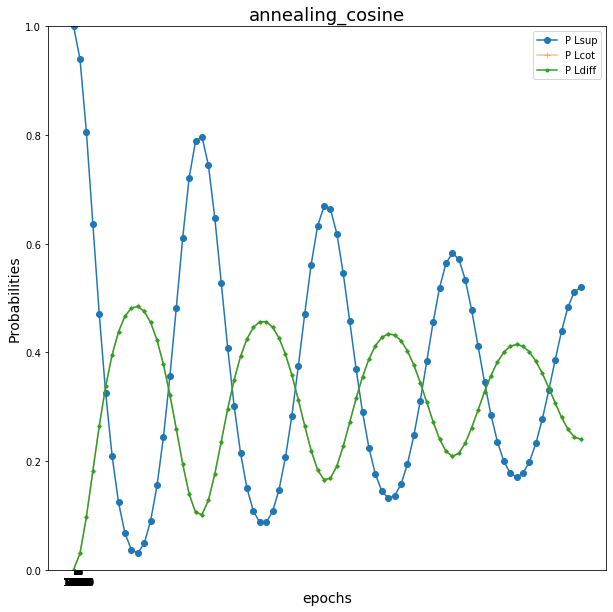

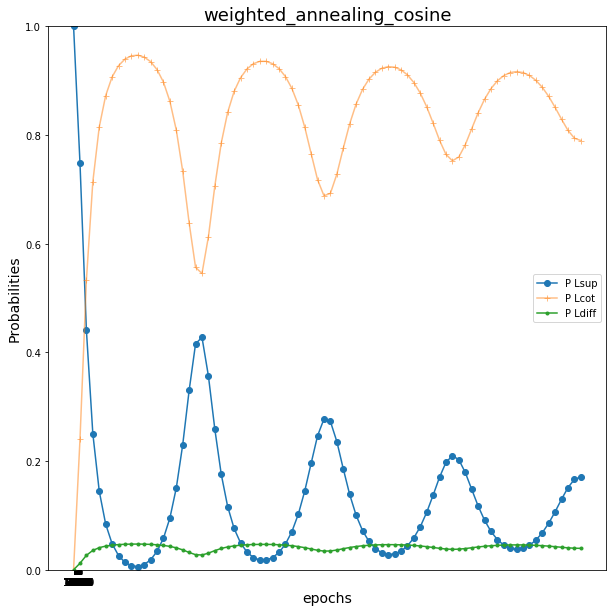

In [173]:
schedulers = [
#     rule_maker_linear, rule_maker_weighted_linear,
#     rule_maker_sigmoid, rule_maker_weighted_sigmoid,
#     rule_maker_cosine, rule_maker_weighted_cosine,
    rule_maker_annealing_cosine, rule_maker_weighted_annealing_cosine,
]
steps = 10
cycle = 8

for rule_fn in schedulers:
    rules = rule_fn(steps, cycle=cycle, beta=1)
    display(rules, rule_fn.__name__[11:])


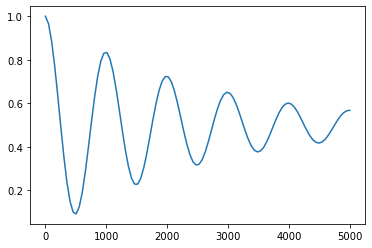

In [145]:
step = 10
cycle = 10
decay = 2
hop_length = hop_length = np.linspace(0, args.nb_epoch, step * cycle)

# create original steps
decaying =  np.exp(-decay*np.linspace(0, 1, len(hop_length)))
sup_steps = 0.5 * (decaying * np.cos(np.pi * hop_length / (args.nb_epoch / cycle)) + 1)

plt.plot(hop_length, sup_steps)